UTKFace dataset is a large-scale face dataset consisting of over 20,000 images. The images cover a wide range of ages and races and include both males and females. Using this dataset, I will be attempting to create a CNN model to predict the age and gender of an individual.

Import libraries

In [1]:
import os, shutil
from matplotlib.image import imread
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Load the dataset

In [2]:
folder = '../input/utkface-new/UTKFace'
f_list = os.listdir(folder)
f_num = len(f_list)
print('Number of images:', f_num)
print(f_list[0])

Number of images: 23708

26_0_2_20170104023102422.jpg.chip.jpg


In [3]:
df = pd.DataFrame(f_list, columns = ['f_name'])
df['f_path'] = df.apply(lambda x : os.path.join(folder, x['f_name']), axis = 1)
df['age'] = df.apply(lambda x : x['f_name'].split('_')[0], axis = 1).astype('float')
df['gender'] = df.apply(lambda x : x['f_name'].split('_')[1], axis = 1).astype('int')
df.head()

,f_name,f_path,age,gender
0,26_0_2_20170104023102422.jpg.chip.jpg,../input/utkface-new/UTKFace/26_0_2_2017010402...,26.0,0
1,22_1_1_20170112233644761.jpg.chip.jpg,../input/utkface-new/UTKFace/22_1_1_2017011223...,22.0,1
2,21_1_3_20170105003215901.jpg.chip.jpg,../input/utkface-new/UTKFace/21_1_3_2017010500...,21.0,1
3,28_0_0_20170117180555824.jpg.chip.jpg,../input/utkface-new/UTKFace/28_0_0_2017011718...,28.0,0
4,17_1_4_20170103222931966.jpg.chip.jpg,../input/utkface-new/UTKFace/17_1_4_2017010322...,17.0,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 23708 entries, 0 to 23707

Data columns (total 4 columns):

 #   Column  Non-Null Count  Dtype  

---  ------  --------------  -----  

 0   f_name  23708 non-null  object 

 1   f_path  23708 non-null  object 

 2   age     23708 non-null  float64

 3   gender  23708 non-null  int64  

dtypes: float64(1), int64(1), object(2)

memory usage: 741.0+ KB


Visualize and Prepare Data

Text(0, 0.5, 'count')

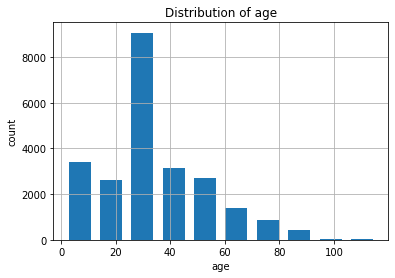

In [5]:
df['age'].hist(rwidth=0.7)
plt.title('Distribution of age')
plt.xlabel('age')
plt.ylabel('count')

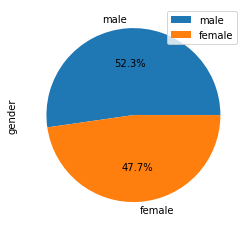

In [6]:
df['gender'].value_counts().plot.pie(autopct="%1.1f%%", labels = ['male' , 'female'])
plt.legend()

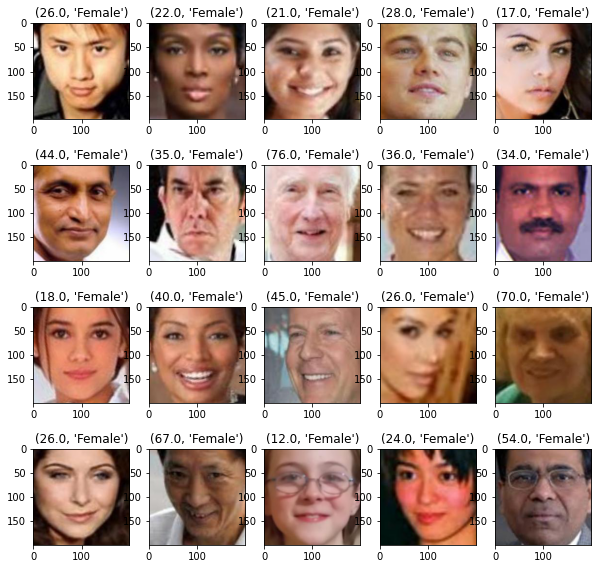

In [7]:
plt.figure(figsize=(10,10))

for i in range(20):
  plt.subplot(4,5,i+1)
  file = df['f_path'][i]
  image = imread(file)
  plt.imshow(image)
  plt.title((df['age'][i], 'Male' if df['gender'][i] == '0' else 'Female'))

In [8]:
from sklearn.model_selection import train_test_split

training_data, validation_data = train_test_split(df, test_size=0.2)

n_train = len(training_data)
n_val = len(validation_data)

print('No. of training image:', n_train)
print('No. of validation image:', n_val)

No. of training image: 18966

No. of validation image: 4742


In [9]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 64

train_generator = train_datagen.flow_from_dataframe(training_data, 
                                                    directory=folder, 
                                                    x_col = 'f_name', 
                                                    y_col = ['age', 'gender'], 
                                                    target_size = (128, 128),
                                                    class_mode = 'multi_output',
                                                    batch_size = batch_size)

val_generator = val_datagen.flow_from_dataframe(validation_data, 
                                                directory=folder, 
                                                x_col = 'f_name', 
                                                y_col = ['age', 'gender'], 
                                                target_size = (128, 128),
                                                class_mode = 'multi_output',
                                                batch_size = batch_size)


Found 18966 validated image filenames.

Found 4742 validated image filenames.


Build the CNN network

2022-06-12 16:19:08.201778: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "model"

__________________________________________________________________________________________________

Layer (type)                    Output Shape         Param #     Connected to                     


input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            

__________________________________________________________________________________________________

conv2d (Conv2D)                 (None, 126, 126, 32) 896         input_1[0][0]                    

__________________________________________________________________________________________________

max_pooling2d (MaxPooling2D)    (None, 63, 63, 32)   0           conv2d[0][0]                     

__________________________________________________________________________________________________

conv2d_1 (Conv2D)               (None, 61, 61, 64)   18496       max_pooling2d[0][0]              

___________________________________________________________________________________

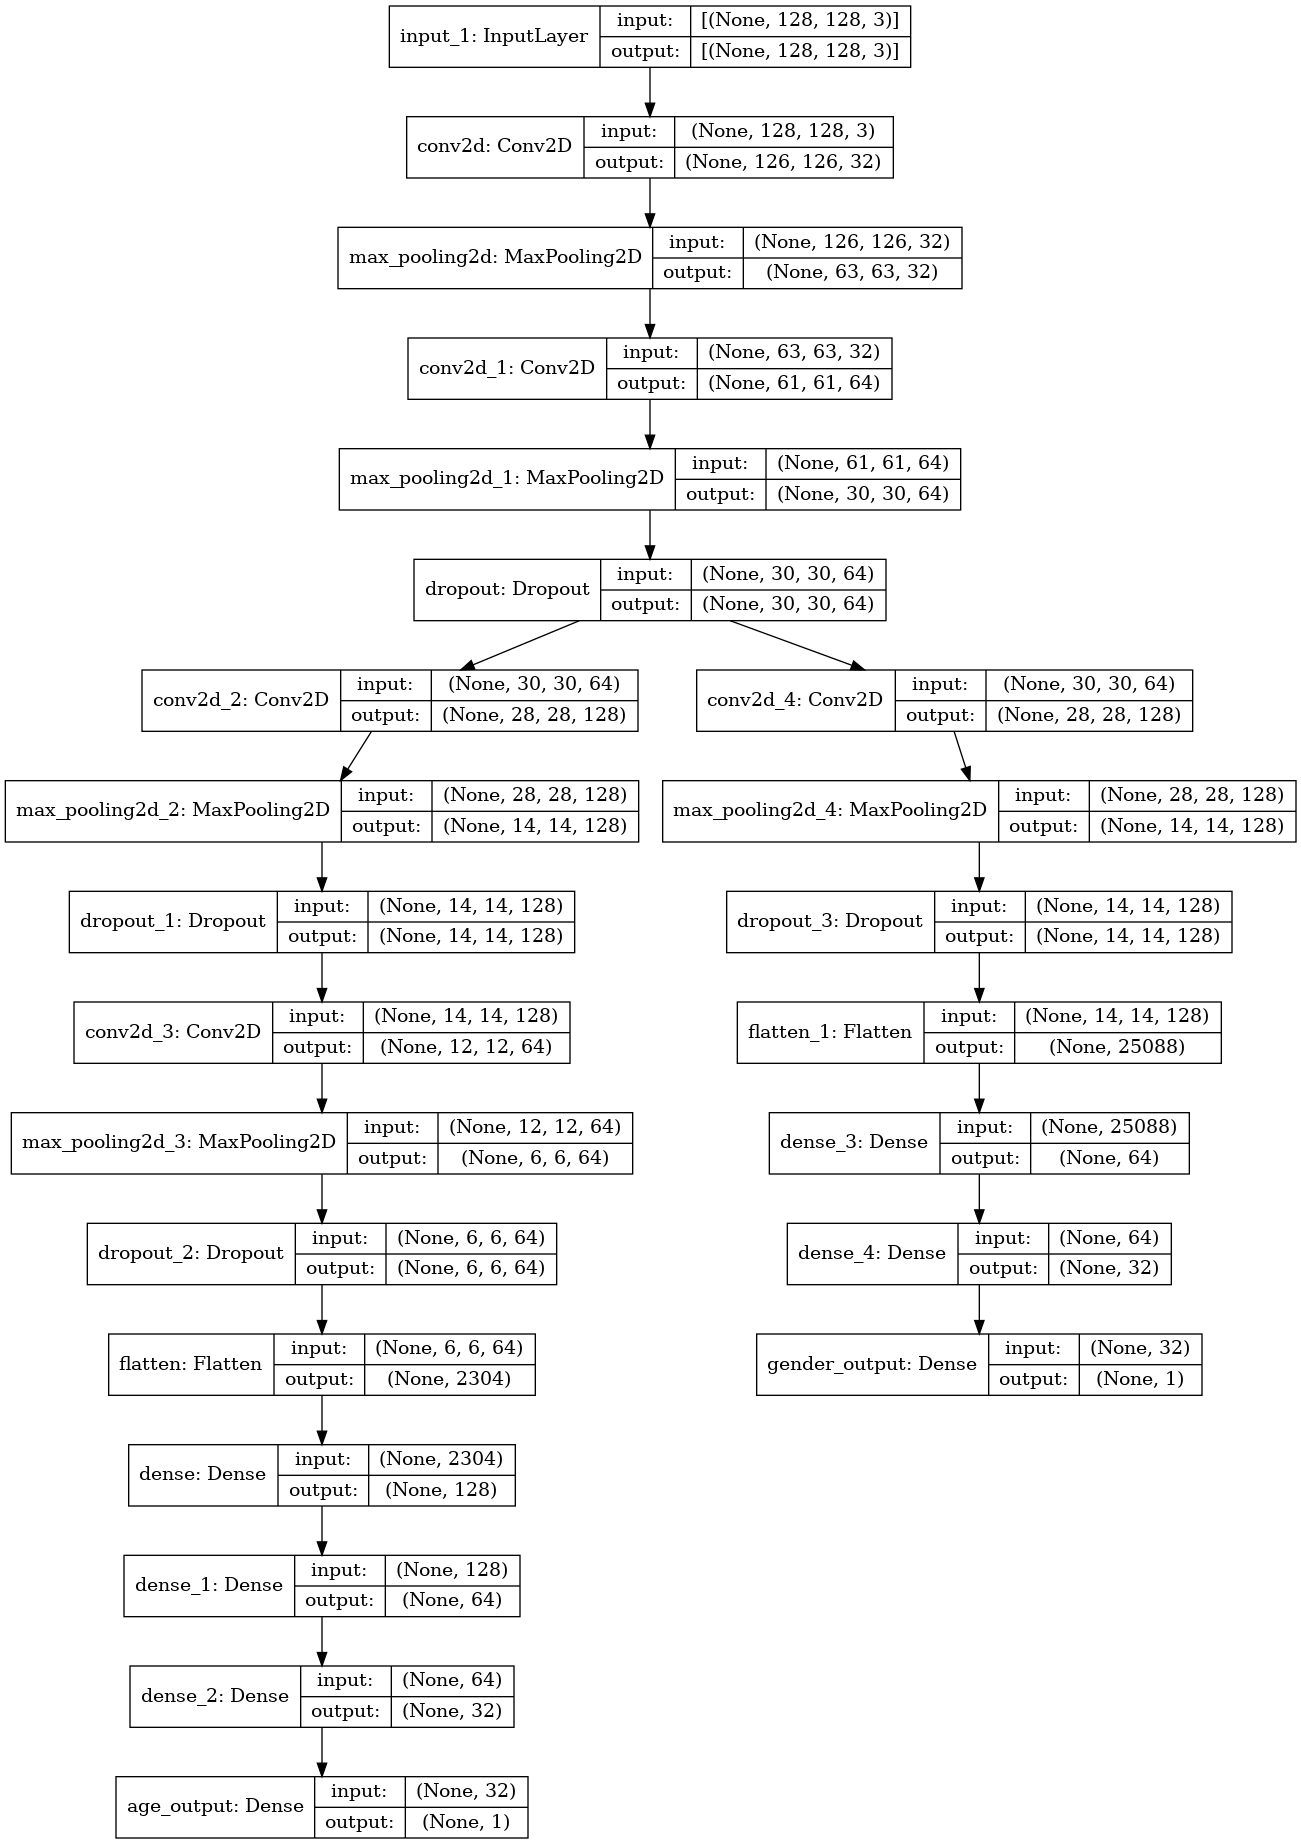

In [10]:
from keras import Model, Input
from keras.layers import Conv2D, Activation, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization


inputs = Input(shape=(128, 128, 3))

base_model = Conv2D(32, (3, 3), activation = 'relu')(inputs)
base_model = MaxPooling2D((2, 2))(base_model)
base_model = Conv2D(64, (3, 3), activation = 'relu')(base_model)
base_model = MaxPooling2D((2, 2))(base_model)
base_model = Dropout(0.5)(base_model)


age_model = base_model
age_model = Conv2D(128, (3, 3), activation = 'relu')(age_model)
age_model = MaxPooling2D((2, 2))(age_model)
age_model = Dropout(0.25)(age_model)
age_model = Conv2D(64, (3, 3), activation = 'relu')(age_model)
age_model = MaxPooling2D((2, 2))(age_model)
age_model = Dropout(0.25)(age_model)
age_model = Flatten()(age_model)
age_model = Dense(128, activation = 'relu')(age_model)
age_model = Dense(64, activation = 'relu')(age_model)
age_model = Dense(32, activation = 'relu')(age_model)
age_model = Dense(1, activation = 'linear', name='age_output')(age_model)


gender_model = base_model
gender_model = Conv2D(128, (3, 3), activation = 'relu')(gender_model)
gender_model = MaxPooling2D((2, 2))(gender_model)
gender_model = Dropout(0.5)(gender_model)
gender_model = Flatten()(gender_model)
gender_model = Dense(64, activation = 'relu')(gender_model)
gender_model = Dense(32, activation = 'relu')(gender_model)
gender_model = Dense(1, activation = 'sigmoid', name='gender_output')(gender_model)

model = Model(inputs=inputs, outputs=[age_model, gender_model])

model.summary()

from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True)

Train the model

In [11]:
from keras import callbacks

earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)

model.compile(loss={'age_output':'mse','gender_output':'binary_crossentropy'},
            optimizer='adam',
            metrics={'age_output':'mae','gender_output':'accuracy'})

history = model.fit(train_generator,
                    steps_per_epoch = n_train // batch_size, 
                    epochs=50,
                    batch_size = batch_size,
                    validation_data=val_generator,
                    validation_steps = n_val // batch_size,
                    callbacks = [earlystopping])

2022-06-12 16:19:10.789807: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50

296/296 [==============================] - 326s 1s/step - loss: 428.6197 - age_output_loss: 428.0342 - gender_output_loss: 0.5857 - age_output_mae: 15.9086 - gender_output_accuracy: 0.6823 - val_loss: 385.8843 - val_age_output_loss: 385.4350 - val_gender_output_loss: 0.4494 - val_age_output_mae: 14.3822 - val_gender_output_accuracy: 0.8074

Epoch 2/50

296/296 [==============================] - 312s 1s/step - loss: 304.4013 - age_output_loss: 303.9781 - gender_output_loss: 0.4230 - age_output_mae: 13.3320 - gender_output_accuracy: 0.8042 - val_loss: 317.1239 - val_age_output_loss: 316.7601 - val_gender_output_loss: 0.3639 - val_age_output_mae: 12.7466 - val_gender_output_accuracy: 0.8431

Epoch 3/50

296/296 [==============================] - 313s 1s/step - loss: 215.6212 - age_output_loss: 215.2547 - gender_output_loss: 0.3665 - age_output_mae: 10.9019 - gender_output_accuracy: 0.8327 - val_loss: 200.1075 - val_age_output_loss: 199.7807 - val_gender_output_loss: 0.3267 - v

Evaluate the performance

Text(0.5, 0, 'epoch')

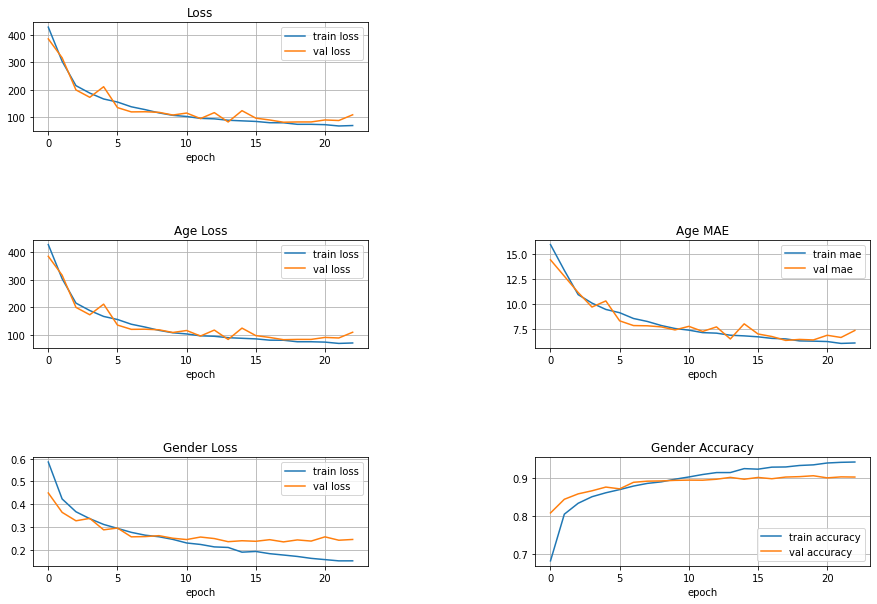

In [12]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15,10))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=1)

fig.add_subplot(3,2,1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.legend()
plt.grid(True)
plt.xlabel('epoch')

fig.add_subplot(3,2,3)
plt.plot(history.history['age_output_loss'], label='train loss')
plt.plot(history.history['val_age_output_loss'], label='val loss')
plt.title('Age Loss')
plt.legend()
plt.grid(True)
plt.xlabel('epoch')

fig.add_subplot(3,2,4)
plt.plot(history.history['age_output_mae'], label='train mae')
plt.plot(history.history['val_age_output_mae'], label='val mae')
plt.title('Age MAE')
plt.legend()
plt.grid(True)
plt.xlabel('epoch')

fig.add_subplot(3,2,5)
plt.plot(history.history['gender_output_loss'], label='train loss')
plt.plot(history.history['val_gender_output_loss'], label='val loss')
plt.title('Gender Loss')
plt.legend()
plt.grid(True)
plt.xlabel('epoch')

fig.add_subplot(3,2,6)
plt.plot(history.history['gender_output_accuracy'], label='train accuracy')
plt.plot(history.history['val_gender_output_accuracy'], label='val accuracy')
plt.title('Gender Accuracy')
plt.legend()
plt.grid(True)
plt.xlabel('epoch')